In [ ]:
#Raques McGill
#Code retrieved from Python for Finance Cookbook by Eryk Lewinson

In [2]:
## Evaluating the performance of a basic 1/n portfolio 
# 1. Import the libraries:
import yfinance as yf #Provides historical stock data from Yahoo Finance
import numpy as np #Provides fast mathematical function processing
import pandas as pd #Used for Data Science processes to make indexing easy
# import pyfolio as pf
from matplotlib import pyplot as plt #Machine Learning library to create plots and data visualizations
# import pyfolio as pf

# 2. Set up the parameters:
RISKY_ASSETS = ['AMZN', 'WMT', 'BAC', 'CVS'] 
START_DATE = '2017-10-10' 
END_DATE = '2020-10-09'
n_assets = len(RISKY_ASSETS) 

# 3. Download the stock prices from Yahoo Finance:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE, adjusted=True)
# 4. Calculate individual asset returns:
returns = prices_df['Adj Close'].pct_change().dropna() 

# 5. Define the weights:
portfolio_weights = n_assets * [1 / n_assets] 

# 6. Calculate the portfolio returns:
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index=returns.index)


[*********************100%***********************]  4 of 4 completed


[*********************100%***********************]  4 of 4 completed


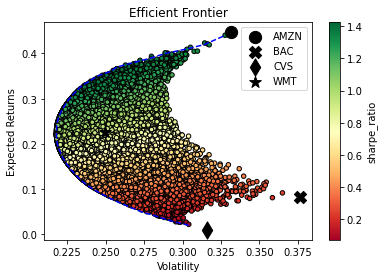

In [3]:
## Finding the Efficient Frontier using Monte Carlo simulations 
# 1. Import the libraries:
import yfinance as yf 
import numpy as np 
import pandas as pd

# 2. Set up the parameters:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252
RISKY_ASSETS = ['AMZN', 'WMT', 'BAC', 'CVS'] #creates list of stock ticker symbols
RISKY_ASSETS.sort() #sorts ticker symbols alphabetically
START_DATE = '2017-10-10' 
END_DATE = '2020-10-09'
n_assets = len(RISKY_ASSETS) #stores the number of stocks as variable 

# 3. Download the stock prices from Yahoo Finance:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE, adjusted=True)

# 4. Calculate annualized average returns and the corresponding standard deviation:
returns_df = prices_df['Adj Close'].pct_change().dropna() 
avg_returns = returns_df.mean() * N_DAYS 
cov_mat = returns_df.cov() * N_DAYS

# 5. Simulate random portfolio weights: 
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets)) 
weights /= np.sum(weights, axis=1)[:, np.newaxis]

# 6. Calculate the portfolio metrics:
portf_rtns = np.dot(weights, avg_returns) 
portf_vol = []
for i in range(0, len(weights)): 
        portf_vol.append(np.sqrt(np.dot(weights[i].T, np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol) 
portf_sharpe_ratio = portf_rtns / portf_vol

# 7. Create a DataFrame containing all the data:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, \
                                 'sharpe_ratio': portf_sharpe_ratio})

# 8. Locate the points creating the Efficient Frontier:
N_POINTS = 100 
portf_vol_ef = [] 
indices_to_skip = []
portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2) 
portf_rtns = np.round(portf_rtns, 2)
for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns: 
        indices_to_skip.append(point_index) 
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind])) 
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip) 

# 9. Plot the Efficient Frontier:
MARKS = ['o', 'X', 'd', '*'] 
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio', \
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--') 
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), \
               y=avg_returns[asset_index], marker=MARKS[asset_index], s=150,
    color='black', label=RISKY_ASSETS[asset_index]) 
ax.legend()



Minimum volatility portfolio ----
Performance
Return: 22.50% 
Weights
Volatility: 21.80% 
Weights
Sharpe Ratio: 103.22% 
Weights
AMZN: 22.11% BAC: 6.52% CVS: 18.93% WMT: 52.45% 

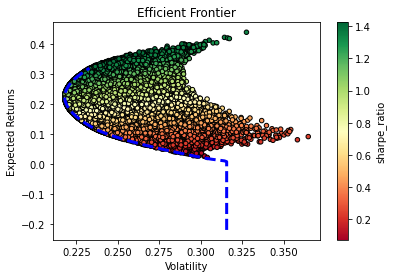

In [4]:
## Finding the Efficient Frontier using optimization with scipy 
# 1. Import the libraries: 
import numpy as np
import scipy.optimize as sco #A scientific computing package for Python

# 2. Define functions for calculating portfolio returns and volatility:
def get_portf_rtn(w, avg_rtns): 
    return np.sum(avg_rtns * w)
def get_portf_vol(w, avg_rtns, cov_mat): 
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

# 3. Define the function calculating the Efficient Frontier:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range): 
    efficient_portfolios = [] 
    n_assets = len(avg_returns) 
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ] 
    for ret in rtns_range:
        constraints = ({'type': 'eq',
        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, args=args,
        method='SLSQP',
        constraints=constraints, bounds=bounds)
        efficient_portfolios.append(efficient_portfolio) 
    return efficient_portfolios

# 4. Define the considered range of returns: 
rtns_range = np.linspace(-0.22, 0.32, 200) 

# 5. Calculate the Efficient Frontier:
efficient_portfolios = get_efficient_frontier(avg_returns, cov_mat, rtns_range)

# 6. Extract the volatilities of the efficient portfolios: 
vols_range = [x['fun'] for x in efficient_portfolios]

# 7. Plot the calculated Efficient Frontier, together with the simulated portfolios: 
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio', \
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3) 
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')

# 8. Identify the minimum volatility portfolio:
min_vol_ind = np.argmin(vols_range) 
min_vol_portf_rtn = rtns_range[min_vol_ind] 
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']
min_vol_portf = {'Return': min_vol_portf_rtn, 'Volatility': min_vol_portf_vol, \
                 'Sharpe Ratio': (min_vol_portf_rtn / min_vol_portf_vol)}

# 9. Print the performance summary:
print('Minimum volatility portfolio ----') 
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True) 
    print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']): print(f'{x}: {100*y:.2f}% ', end="", flush=True)

# Running the code results in the following summary:
    
# The following image presents a graph of the Efficient Frontier, calculated using numerical optimization:



C:\Users\raque.DESKTOP-HNFKI91\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


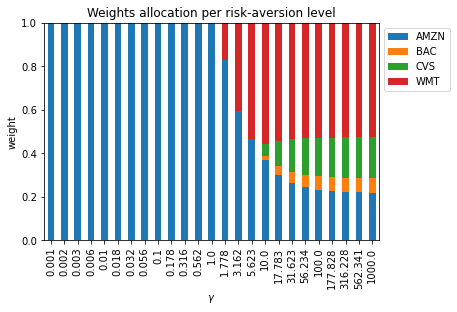

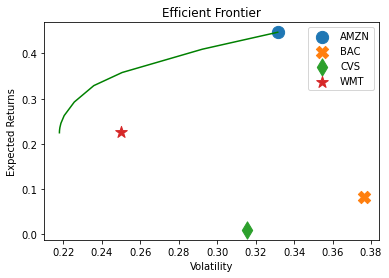

In [5]:
## Finding the Efficient Frontier using convex optimization with cvxpy 
# 1. Import the library: 
import cvxpy as cp #A Python-embedded modeling language for convex optimization problems

# 2. Convert the annualized average returns and the covariance matrix to numpy arrays:
avg_returns = avg_returns.values 
cov_mat = cov_mat.values

# 3. Set up the optimization problem:
weights = cp.Variable(n_assets) 
gamma = cp.Parameter(nonneg=True) 
portf_rtn_cvx = avg_returns * weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat) 
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function, [cp.sum(weights) == 1, weights >= 0])

# 4. Calculate the Efficient Frontier: 
N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS) 
portf_vol_cvx_ef = np.zeros(N_POINTS) 
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)
for i in range(N_POINTS): 
    gamma.value = gamma_range[i] 
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value 
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value 
    weights_ef.append(weights.value)

# 5. Plot the allocation for different values of the risk-aversion parameter: 
weights_df = pd.DataFrame(weights_ef,
                          columns=RISKY_ASSETS, index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(title='Weights allocation per risk-aversion level', xlabel=r'$\gamma$', ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

# 6. Plot the Efficient Frontier, together with the individual assets: 
fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-') 
for asset_index in range(n_assets):
    plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), y=avg_returns[asset_index], \
                marker=MARKS[asset_index], label=RISKY_ASSETS[asset_index], s=150)
ax.set(title='Efficient Frontier', xlabel='Volatility', ylabel='Expected Returns', )
ax.legend()

Retrieved from Python for Finance Cookbook by Eryk Lewinson
Asset Allocation in Python
Asset allocation, spreading the investor's total investment amount over certain assets, is the most important decision that any investor needs to face. When considering the allocation, the investor wants to balance the risk and the potential reward. At the same time, the allocation is dependent on factors such as the individual goals (expected return), risk tolerance (how much risk is the investor willing to accept), or the investment horizon (short or long-term investment).
The key framework in asset allocation is the modern portfolio theory (MPT, also known as mean-variance analysis). It describes how risk-averse investors can construct portfolios to maximize their expected returns (profits) for a given level of risk. The main insight from MPT is that investors should not evaluate an asset's performance alone (by metrics such as expected return or volatility) but instead investigate how it would impact the performance of their portfolio of assets.
MPT is closely related to the concept of diversification, which simply means that owning different kinds of assets reduces risk, as the loss or gain of a particular security has less impact on the portfolio’s performance. Another key concept to be aware of is that while the portfolio return is the weighted average of the individual asset returns, this is not true for the risk (volatility). It is also dependent on the correlations between the assets. Because of optimized asset allocation, it is possible to have a portfolio with lower volatility than the lowest individual volatility of the assets in the portfolio. In principle, the lower the correlation between the assets we hold, the better it is for diversification. With a perfect negative correlation, we could diversify all the risk. 
Here, we start with the most basic asset allocation strategy and learn how to evaluate the performance of portfolios (also applicable to individual assets). Later, we show two different approaches to obtaining the Efficient Frontier, while also relaxing some of the assumptions of MPT. One of the main benefits of learning how to approach optimization problems is that they can be easily refactored, for example, optimizing a different objective function. This requires only slight modifications to the code, while the majority of the framework stays the same.
Evaluating the performance of a basic 1/n portfolio
We begin with inspecting the most basic asset allocation strategy: the 1/n portfolio. The idea is to assign equal weights to all the considered assets, thus diversifying the portfolio. The goal here is to show how to create a 1/n portfolio and calculate its returns.
In Steps 1 to 4, we followed the already established approach—imported the libraries, set up the parameters, downloaded stock prices of four US companies (Amazon, Bank of America, CVS Health, and Walmart) over the years 2017-2020, and calculated simple returns, using the adjusted close prices. In Step 5, we created a list of weights, each one equal to 1 / n_assets, where n_assets is the number of assets we want to have in our portfolio. Next, we calculated the portfolio returns as a matrix multiplication (also known as the dot product—np.dot) of the portfolio weights and a transposed matrix of asset returns. To transpose the matrix, we used the T method of a pandas DataFrame. Then, we stored the portfolio returns as a pandas Series object, because that is the input for the ensuing step.
Finding the Efficient Frontier using Monte Carlo simulations
According to the Modern Portfolio Theory, the Efficient Frontier is a set of optimal portfolios in the risk-return spectrum. This means that the portfolios on the frontier offer the highest expected return for a given level of risk and offer the lowest level of risk for a given level of expected returns. All portfolios located under the Efficient Frontier curve are considered sub-optimal, so it is always better to choose the ones on the frontier instead.
Here, we show how to find the Efficient Frontier using Monte Carlo simulations. We build thousands of portfolios, using randomly assigned weights, and visualize the results. To do so, we use the returns of four US companies from 2017 to 2020.
In Step 2, we defined parameters used for this recipe, such as the considered timeframe, the risky assets we wanted to use for building the portfolio, and the number of simulations. An important thing to note here is that we also ran RISKY_ASSETS.sort(), to sort the list alphabetically. This matters when interpreting the results as when downloading data from Yahoo Finance using the yfinance library, the obtained prices are ordered alphabetically, not as specified in the provided list. Having downloaded the stock prices, we calculated simple returns using the pct_change method of a pandas DataFrame and dropped the first row containing NaNs.
For evaluating the potential portfolios, we needed the average (expected) annual return and the corresponding covariance matrix. We obtained them by using the mean() and cov() methods of the DataFrame. We also annualized both metrics by multiplying them by 252 (the average number of trading days in a year). We needed the covariance matrix, as for calculating the portfolio volatility, we also needed to account for the correlation between the assets. To benefit from significant diversification, the assets should have low positive or negative correlations.
In Step 5, we calculated the random portfolio weights. Following the assumptions of the MPT (refer to the chapter introduction for reference), the weights needed to be positive and sum up to 1. To achieve this, we first generated a matrix of random numbers (between 0 and 1), using np.random.random. The matrix was of size N_SIMULATIONS x N_ASSETS. To make sure the weights totaled 1, we divided each row of the matrix by its sum.
In Step 6, we calculated the portfolio metrics—returns and standard deviation. To calculate the expected annual portfolio returns, we had to multiply the weights by the previously calculated annual averages. For the standard deviations, we had to use the vector of weights and the historical covariance matrix. To calculate the standard deviation, we iterated over all the simulated portfolios, using a for loop.
The for loop implementation is actually faster than the vectorized matrix equivalent: np.diag(np.sqrt(np.dot(weights, np.dot(cov_mat, weights.T)))). The reason for that is the quickly increasing number of off-diagonal elements to be calculated, which, in the end, does not matter for the metrics of interest. This approach is faster than the for loop for only a relatively small number of simulations (~100).
For this example, we assumed that the risk-free rate was 0%, so the Sharpe ratio of the portfolio could be calculated as portfolio returns/portfolio volatility. Another possible approach would be to calculate the average annual risk-free rate, and to use the portfolio excess returns for calculating the ratio.
The last three steps led to visualizing the results. First, we put all the relevant metrics into a pandas DataFrame. Second, we created an array of expected returns from the sample. To do so, we used np.linspace, with the min and max values from the calculated portfolio returns. We rounded the numbers to two decimals, to make the calculations smoother. For each expected return, we found the minimum observable volatility. In cases where there was no match, as can happen with equally spread points on the linear space, we skipped that point.
In the very last step, we plotted the simulated portfolios, the individual assets, and the approximated Efficient Frontier in one plot. The shape of the frontier was a bit jagged, which can be expected when using only simulated values that are not that frequent in some extreme areas. Additionally, we colored the dots representing the simulated portfolios by the value of the Sharpe ratio.
Finding the Efficient Frontier using optimization with scipy
Previously, we used a brute-force approach based on Monte Carlo simulations to visualize the Efficient Frontier. Now, we use a more refined method to determine the frontier.
From its definition, the Efficient Frontier is formed by a set of portfolios offering the highest expected portfolio return for a certain volatility, or offering the lowest risk (volatility) for a certain level of expected returns. We can leverage this fact and use it in numerical optimization. The goal of optimization is to find the best (optimal) value of the objective function by adjusting the target variables and taking into account some boundaries and constraints (which have an impact on the target variables). In this case, the objective function is a function returning portfolio volatility, and the target variables are portfolio weights.
As mentioned in the introduction, we continued the example from the previous recipe. That is why we had to run Step 1 to Step 4 from the previous recipe, Finding the Efficient Frontier using Monte Carlo simulations (not shown here for brevity), to have all the required data. As an extra prerequisite, we had to import the optimization module from scipy.
In Step 2, we defined two functions, which returned the expected portfolio return and volatility, given historical data and the portfolio weights. We had to define these functions instead of calculating these metrics directly, as we used them in the optimization procedure. The algorithm iteratively tries different weights and needs to be able to use the current values of the target variables (weights) to arrive at the metric it tries to optimize.
In Step 3, we defined a function called get_efficient_frontier. Its goal is to return a list containing the efficient portfolios, given historical metrics and the considered range of returns. This was the most important step of the recipe and contained a lot of nuances. We describe the logic of the function sequentially: The outline of the function is that it runs the optimization procedure for each expected return in the considered range, and stores the resulting optimal portfolio in a list.
Outside of the for loop, we define a couple of objects that we pass into the optimizer: The arguments that are passed to the objective function. In this case, these are the historical average returns and the covariance matrix. The function that we optimize must accept the arguments as inputs. That is why we pass the returns to the get_portfolio_volatility function, even though they are not necessary for calculations. Bounds (a nested tuple)—for each target variable (weight), a tuple containing the boundaries—minimum and maximum allowable values. In this case, the values span the range from 0 to 1 (no negative weights, as per the MPT). The goal of using the initial guess, which is the initial guess of the target variables, is to make the optimization run faster and more efficiently. In this case, the guess is the 1/n allocation.
Inside the for loop, we define the last element used for the optimization—the constraints. We define two constraints: The expected portfolio return must be equal to the provided value. The sum of the weights must be equal to 1.
The first constraint is the reason why the constraint's tuple is defined within the loop—as the loop passes over the considered range of expected portfolio returns, and for each value, we find the optimal risk level. We run the optimizer with the Sequential Least-Squares Programming (SLSQP) algorithm, which is frequently used for generic minimization problems. For the function to be minimized, we pass the specially prepared get_portfolio_volatility function.
The optimizer sets the equality (eq) constraint to 0. That is why the intended constraint, np.sum(weights) == 1, is expressed as np.sum(weights) - 1 == 0.
In Steps 4 and 5, we defined the range of expected portfolio returns (based on the range we empirically observed in the previous recipe) and ran the optimization function.
In Step 6, we iterated over the list of efficient portfolios and extracted the optimal volatilities. We extracted the volatility from the scipy.optimize.OptimizeResult object by accessing the fun element. This stands for the optimized objective function—in this case, the portfolio volatility.
In Step 7, we added the calculated Efficient Frontier on top of the plot from the previous recipe, Finding the Efficient Frontier using Monte Carlo simulations. All the simulated portfolios lie on or below the Efficient Frontier, which is what we expected to happen.
In Steps 8 and 9, we identified the minimum volatility portfolio, printed the performance metrics, and showed the portfolio's weights (extracted from the Efficient Frontier).
We can now compare the two minimum volatility portfolios: the one obtained using Monte Carlo simulations, and the one we received from optimization. The prevailing pattern in the allocation is the same—allocate the majority of the available resources to Facebook and Microsoft. We can also see that the volatility of the optimized strategy is slightly lower. This means that among the 100,000 portfolios, we have not simulated the actual minimum volatility portfolio.
